In [1]:
from pathlib import Path

from forecasting_models.univariate_models.arima.model import ARIMAForecastModel

arima_model = ARIMAForecastModel(Path("__file__").parent / Path("examples/configs/arima/auto_arima_config_example.yaml"))

In [2]:
from data_utils.csv_utils import read_timeseries_csv

train_df = read_timeseries_csv(arima_model.config.data_path)

(22595, 1)

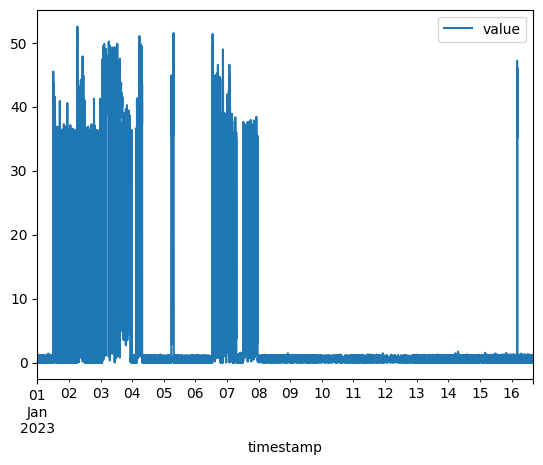

In [3]:
train_df.plot()
train_df.shape

<Axes: xlabel='timestamp'>

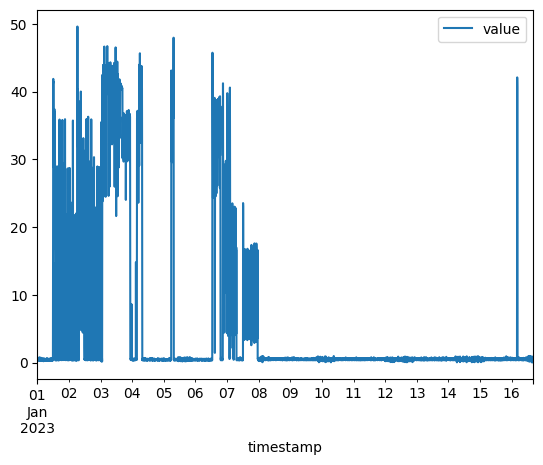

In [4]:
from data_utils.preprocessing import init_preprocess, resample_timeseries_dataframe

# preprocess training dataset to showcase the configured internal pre-processing outcome
preproc_train_df = init_preprocess(
    train_df,
    base_step=arima_model.config.preprocessing_parameters.initial_timedelta,
)
preproc_train_df = resample_timeseries_dataframe(
    preproc_train_df,
    step=arima_model.config.preprocessing_parameters.target_timedelta,
)

preproc_train_df.plot()

In [5]:
arima_model.train()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4519
Model:               SARIMAX(6, 1, 0)   Log Likelihood              -13286.884
Date:                Thu, 11 Apr 2024   AIC                          26587.769
Time:                        10:41:40   BIC                          26632.679
Sample:                    01-01-2023   HQIC                         26603.590
                         - 01-16-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4630      0.005    -86.094      0.000      -0.474      -0.452
ar.L2         -0.3070      0.007    -46.366      0.000      -0.320      -0.294
ar.L3         -0.2541      0.008    -31.241      0.000      -0.270      -0.238
ar.L4         -0.2354      0.009    -25.954      0.000      -0.253      -0.218
ar.L5         -0.2204      0.009    -25.271      0.000      -0.237      -0.203
ar.L6         -0.1866      0.006    -31.891      0.000      -0.198      -0.175
sigma2        20.9827      0.136    153.848      0.000      20.715      21.250
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):             74174.77
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.04   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [6]:
arima_model.order()

(6, 1, 0)

In [7]:
test_df = read_timeseries_csv("./examples/sample_data/resource_usage_example_TEST.csv")

<Axes: xlabel='timestamp'>

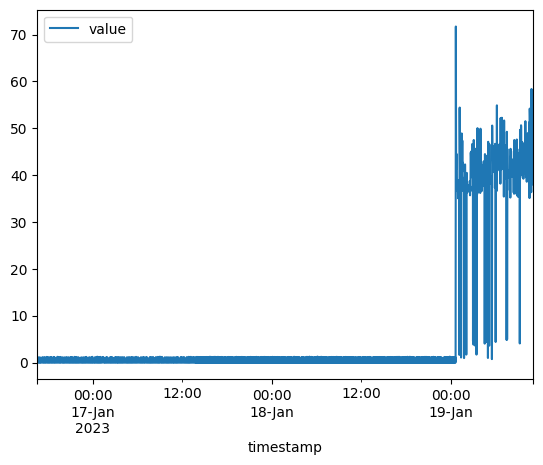

In [8]:
test_df.plot()

<Axes: xlabel='timestamp'>

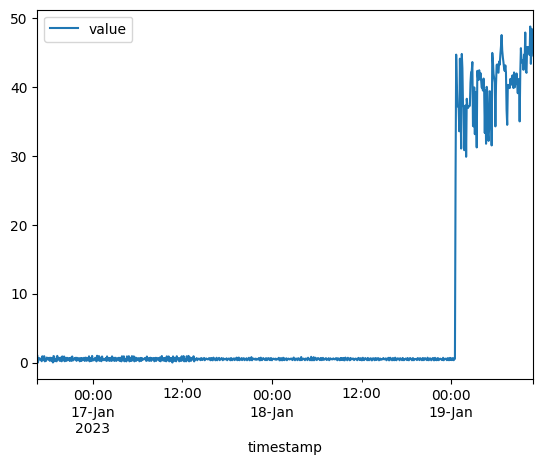

In [9]:
# preprocess training dataset to showcase the configured internal pre-processing outcome
preproc_test_df = init_preprocess(
    test_df,
    base_step=arima_model.config.preprocessing_parameters.initial_timedelta,
)
preproc_test_df = resample_timeseries_dataframe(
    preproc_test_df,
    step=arima_model.config.preprocessing_parameters.target_timedelta,
)

preproc_test_df.plot()

In [10]:
actuals, preds = arima_model.test(test_df)

In [11]:
test_eval_val, test_eval_df = arima_model.evaluate_test(
    actuals,
    preds,
    method="mse",
)

In [12]:
print(test_eval_val)

12.864933607668661


In [13]:
print(test_eval_df)

                        actual  predicted      diff
2023-01-16 16:40:00   0.955621   0.419834  0.535787
2023-01-16 16:45:00   0.007500   0.407206 -0.399706
2023-01-16 16:50:00   0.645425   0.451264  0.194160
2023-01-16 16:55:00   0.445010   0.416790  0.028220
2023-01-16 17:00:00   0.606107   0.484740  0.121367
...                        ...        ...       ...
2023-01-19 10:45:00  43.364818  44.172666 -0.807848
2023-01-19 10:50:00  46.298526  44.608892  1.689633
2023-01-19 10:55:00  48.388678  44.770839  3.617839
2023-01-19 11:00:00  47.379692  44.773186  2.606506
2023-01-19 11:05:00  44.573609  44.918276 -0.344667

[798 rows x 3 columns]


In [14]:
anomaly_df = arima_model.flag_anomalies(actuals, preds, threshold_margin_size=20)

In [15]:
anomaly_count = len(anomaly_df[anomaly_df["is_anomaly"] == 1])
print(f"Anomaly count: {anomaly_count}")

Anomaly count: 6


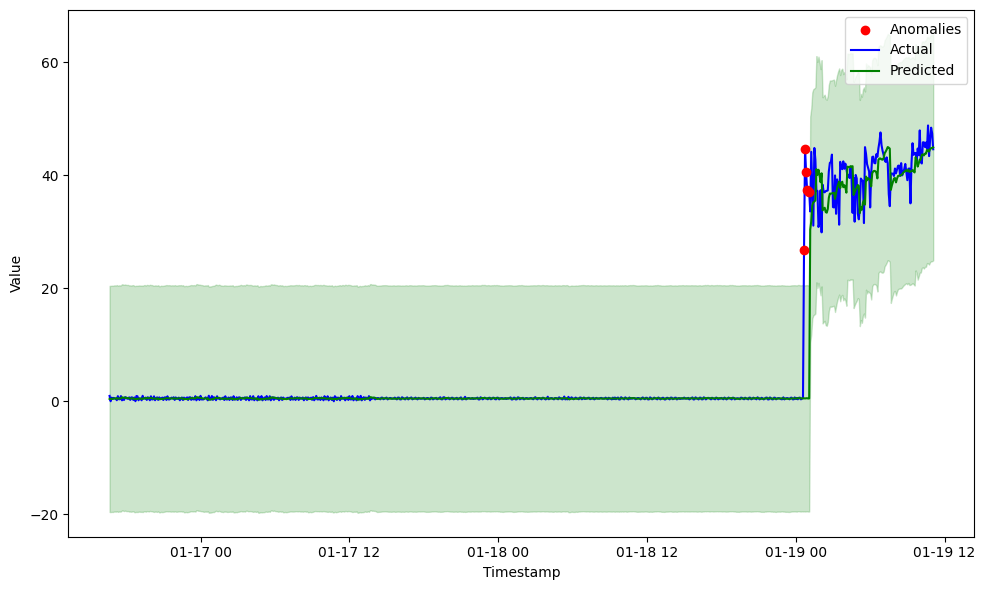

In [16]:
arima_model.plotter.plot_anomalies(anomaly_df, threshold_margin_size=20)

<Axes: xlabel='timestamp'>

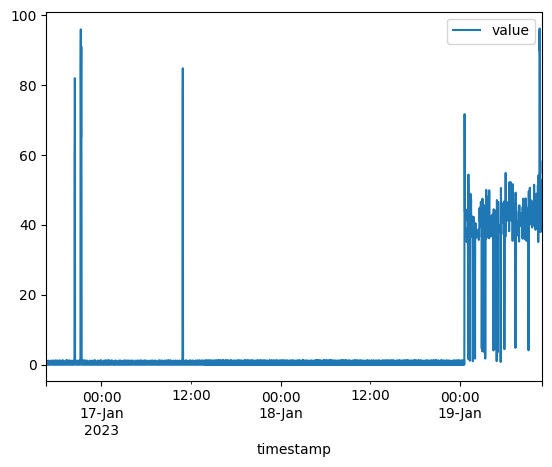

In [17]:
from pathlib import Path


test_df_w_anomalies = read_timeseries_csv(Path("./examples/sample_data/resource_usage_example_ANOMALY_TEST.csv"))

test_df_w_anomalies.plot()

In [18]:
anomaly_actuals, anomaly_preds = arima_model.test(test_df_w_anomalies)

In [19]:
anomaly_df_test = arima_model.flag_anomalies(anomaly_actuals, anomaly_preds, threshold_margin_size=20)

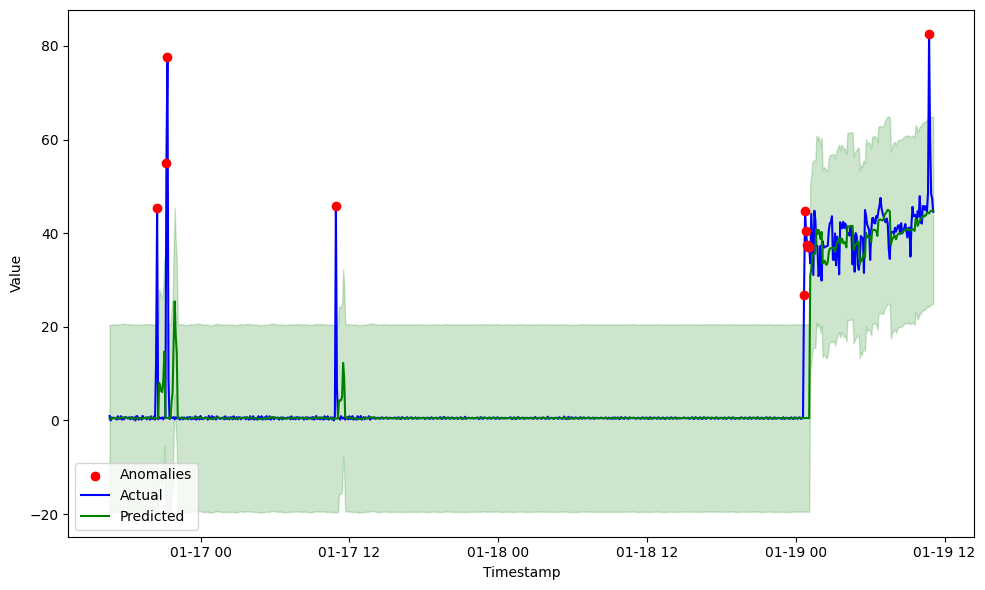

In [20]:
arima_model.plotter.plot_anomalies(anomaly_df_test, threshold_margin_size=20)

In [21]:
import pandas as pd

single_shot_preds = arima_model.predict(pd.Timestamp(preproc_test_df["value"].index[0]) - pd.Timedelta(arima_model.config.preprocessing_parameters.target_timedelta))
print(single_shot_preds)

2023-01-16 16:35:00    0.419834
2023-01-16 16:40:00    0.407206
2023-01-16 16:45:00    0.451264
2023-01-16 16:50:00    0.416790
2023-01-16 16:55:00    0.484740
2023-01-16 17:00:00    0.503410
Freq: 5min, dtype: float64


In [22]:
single_shot_eval_val, single_shot_eval_df = arima_model.evaluate_prediction(
    preproc_test_df[:arima_model.config.forecasting_parameters.forecast_horizon_size]["value"],
    method="mse",
)

In [23]:
print(single_shot_eval_val)

0.08334675306606125


In [24]:
print(single_shot_eval_df)

                       actual  predicted      diff
2023-01-16 16:35:00  0.955621   0.419834  0.535787
2023-01-16 16:40:00  0.007500   0.407206 -0.399706
2023-01-16 16:45:00  0.645425   0.451264  0.194160
2023-01-16 16:50:00  0.445010   0.416790  0.028220
2023-01-16 16:55:00  0.606107   0.484740  0.121367
2023-01-16 17:00:00  0.498605   0.503410 -0.004805
